In [22]:
from tqdm import tqdm

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
def lorenz_system(t, state, sigma, rho, beta):
    x, y, z = state

    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z

    return [dxdt, dydt, dzdt]


def simulate_lorenz(
    sigma,
    rho,
    beta,
    initial_state,
    t_span,
    num_points=10000
    ):
    t_eval = np.linspace(t_span[0], t_span[1], num_points)

    solution = solve_ivp(
        lambda t, state: lorenz_system(t, state, sigma, rho, beta),
        t_span,
        initial_state,
        t_eval=t_eval,
        method='RK45'
    )

    return solution.t, solution.y

In [5]:
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    normalized_data = scaler.fit_transform(data.T).T
    return normalized_data, scaler


def create_sequences(data, seq_length):
    xs, ys = [], []

    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [7]:
sigma = 10
rho = 28
beta = 8/3
initial_state = [1.0, 1.0, 1.0]
t_span = (0, 100)
num_points = 10000

In [8]:
times, states = simulate_lorenz(
    sigma,
    rho,
    beta,
    initial_state,
    t_span,
    num_points
    )

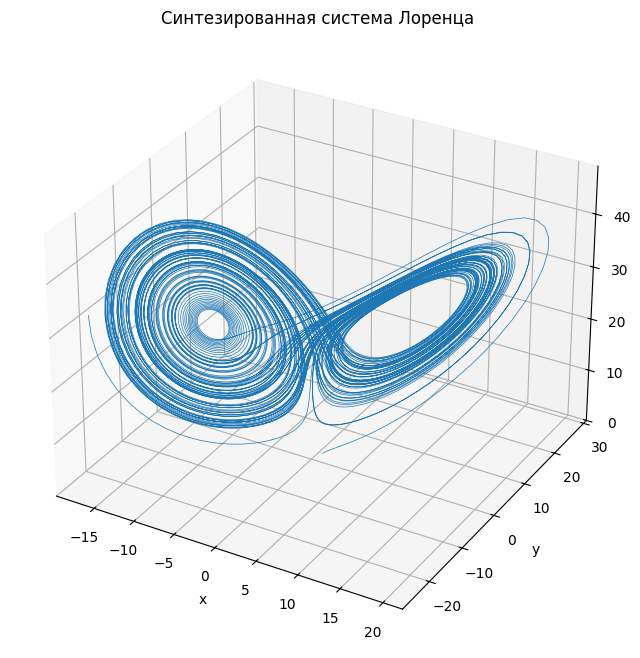

In [9]:
def plot_lorenz_3d(data, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(data[:, 0], data[:, 1], data[:, 2], lw=0.5)

    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    plt.show()


plot_lorenz_3d(states.T, title="Синтезированная система Лоренца")

In [10]:
normalized_states, scaler = normalize_data(states)
print(normalized_states.shape)

(3, 10000)


In [11]:
normalized_states = normalized_states.T
print(normalized_states.shape)

(10000, 3)


In [12]:
seq_length = 50
X, y = create_sequences(normalized_states, seq_length)

print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: (9950, 50, 3)
y: (9950, 3)


In [14]:
if X.shape[0] == 0 or y.shape[0] == 0:
    raise ValueError
else:
    pass

In [15]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [25]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([7960, 50, 3])
torch.Size([7960, 3])
torch.Size([1990, 50, 3])
torch.Size([1990, 3])


In [26]:
input_dim = 3
hidden_dim = 100
layer_dim = 3
output_dim = 3
dropout_prob = 0.3

In [27]:
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout_prob)

In [34]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [45]:
num_epochs = 100

In [46]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

 10%|█         | 10/100 [03:43<33:05, 22.06s/it]

Epoch [10/100], Loss: 0.0209


 20%|██        | 20/100 [07:23<29:20, 22.01s/it]

Epoch [20/100], Loss: 0.0053


 30%|███       | 30/100 [11:03<25:48, 22.12s/it]

Epoch [30/100], Loss: 0.0031


 40%|████      | 40/100 [14:46<21:56, 21.94s/it]

Epoch [40/100], Loss: 0.0019


 50%|█████     | 50/100 [18:32<18:56, 22.73s/it]

Epoch [50/100], Loss: 0.0013


 60%|██████    | 60/100 [22:21<15:24, 23.12s/it]

Epoch [60/100], Loss: 0.0011


 70%|███████   | 70/100 [26:08<11:18, 22.62s/it]

Epoch [70/100], Loss: 0.0010


 80%|████████  | 80/100 [29:46<07:16, 21.81s/it]

Epoch [80/100], Loss: 0.0009


 90%|█████████ | 90/100 [33:35<03:52, 23.28s/it]

Epoch [90/100], Loss: 0.0008


100%|██████████| 100/100 [37:15<00:00, 22.35s/it]

Epoch [100/100], Loss: 0.0007


In [47]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).numpy()
    test_predict = model(X_test_tensor).numpy()

In [48]:
total_params = np.sum(p.numel() for p in model.parameters())
total_params

<ipython-input-48-abc022ddfc6f>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_params = np.sum(p.numel() for p in model.parameters())


203903

In [51]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test_tensor.numpy())

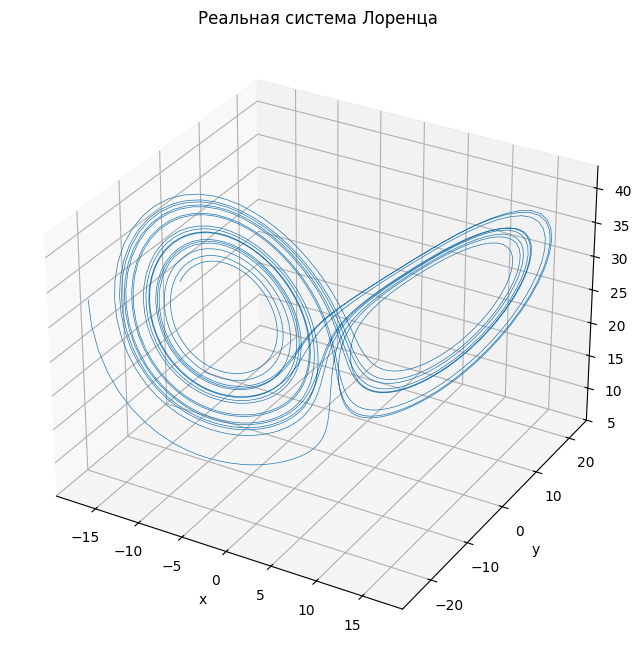

In [52]:
plot_lorenz_3d(y_test_actual, title='Реальная система Лоренца')

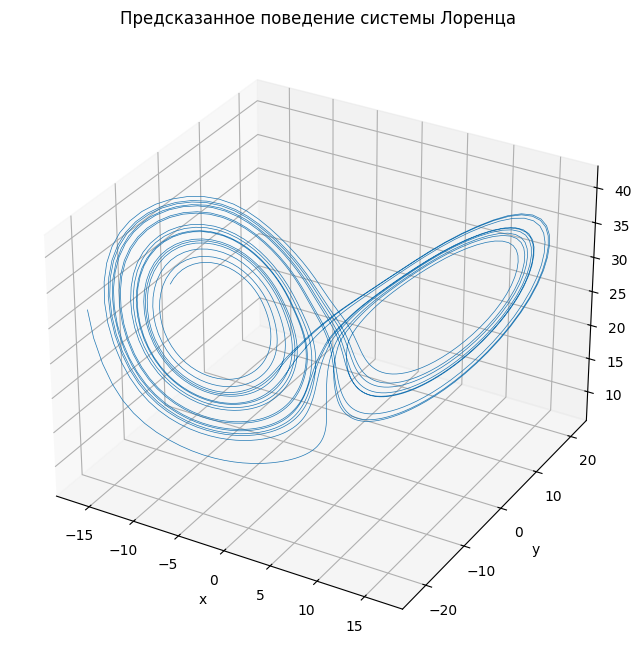

In [53]:
plot_lorenz_3d(test_predict, title='Предсказанное поведение системы Лоренца')

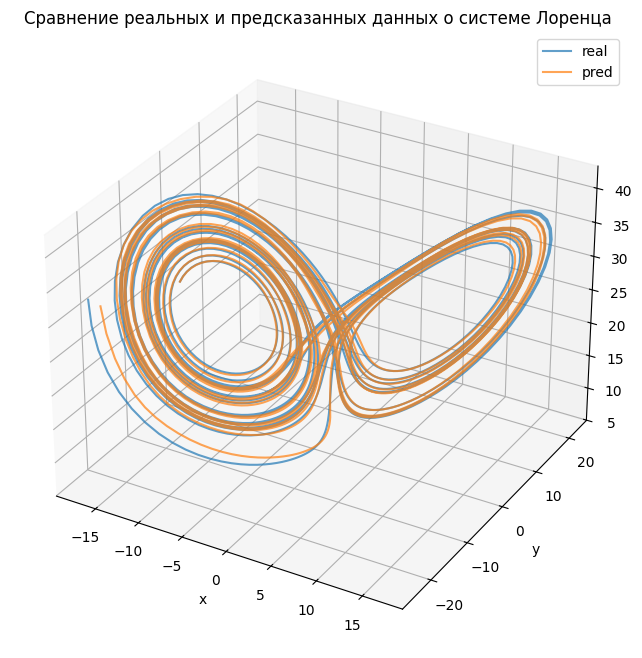

In [57]:
def plot_comparison(real, predicted, title):
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(real[:, 0], real[:, 1], real[:, 2],
            label='real', alpha=0.7)
    ax.plot(predicted[:, 0], predicted[:, 1], predicted[:, 2],
            label='pred', alpha=0.7)

    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.legend()
    plt.show()


plot_comparison(
    y_test_actual,
    test_predict,
    title='Сравнение реальных и предсказанных данных о системе Лоренца'
    )

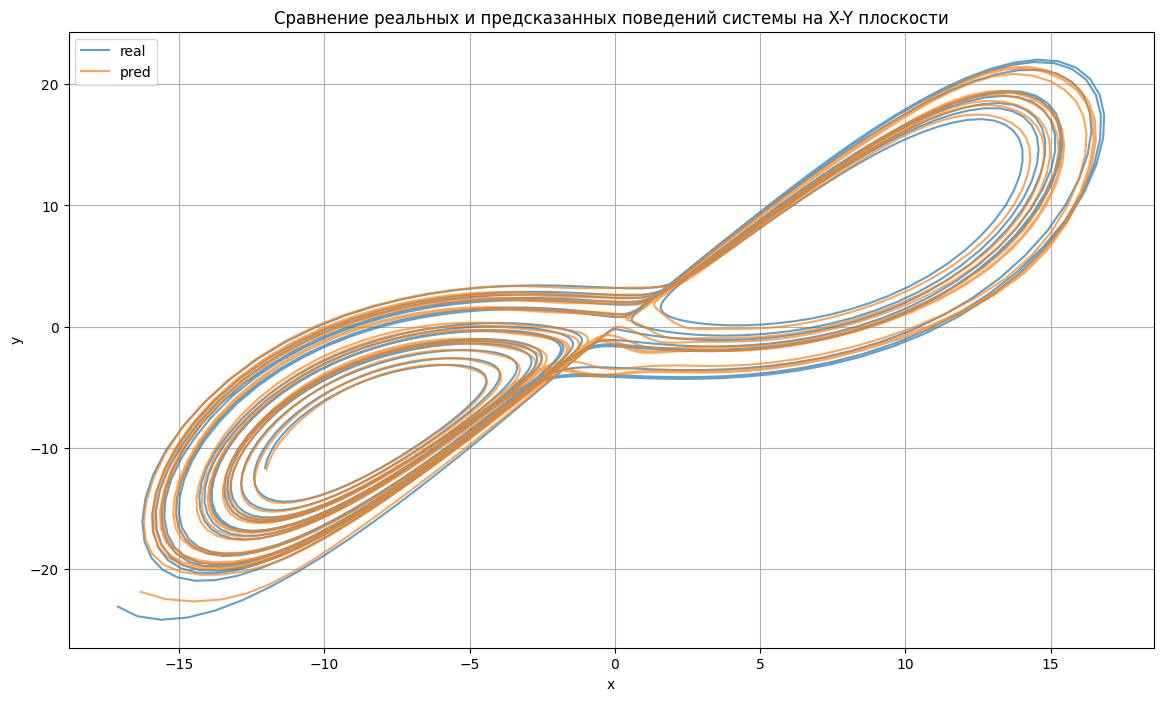

In [58]:
def plot_2d_comparison(real, predicted, title):
    plt.figure(figsize=(14, 8))
    plt.plot(real[:, 0], real[:, 1],
             label='real', alpha=0.7)
    plt.plot(predicted[:, 0], predicted[:, 1],
             label='pred', alpha=0.7)

    plt.title(title)

    plt.xlabel('x')
    plt.ylabel('y')

    plt.legend()
    plt.grid(True)
    plt.show()


plot_2d_comparison(
    y_test_actual,
    test_predict,
    title='Сравнение реальных и предсказанных поведений системы на X-Y плоскости'
    )

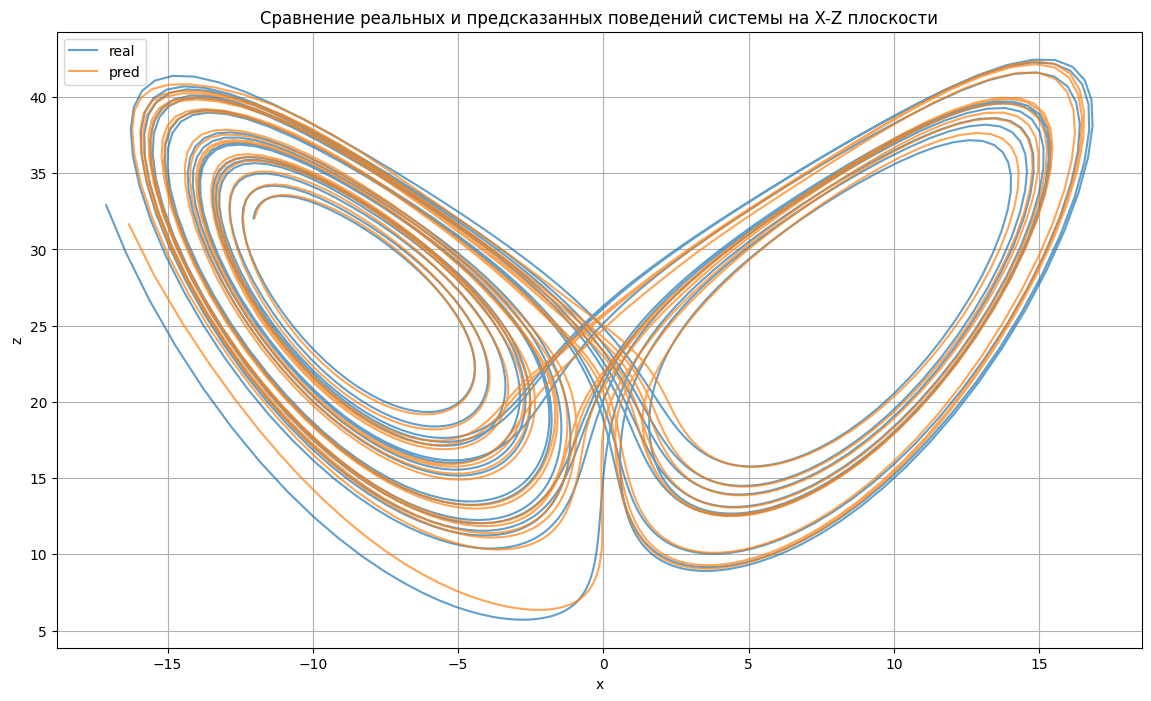

In [59]:
def plot_2d_comparison_xz(real, predicted, title):
    plt.figure(figsize=(14, 8))
    plt.plot(real[:, 0], real[:, 2],
             label='real', alpha=0.7)
    plt.plot(predicted[:, 0], predicted[:, 2],
             label='pred', alpha=0.7)

    plt.title(title)

    plt.xlabel('x')
    plt.ylabel('z')

    plt.legend()
    plt.grid(True)
    plt.show()


plot_2d_comparison_xz(
    y_test_actual,
    test_predict,
    title='Сравнение реальных и предсказанных поведений системы на X-Z плоскости'
    )

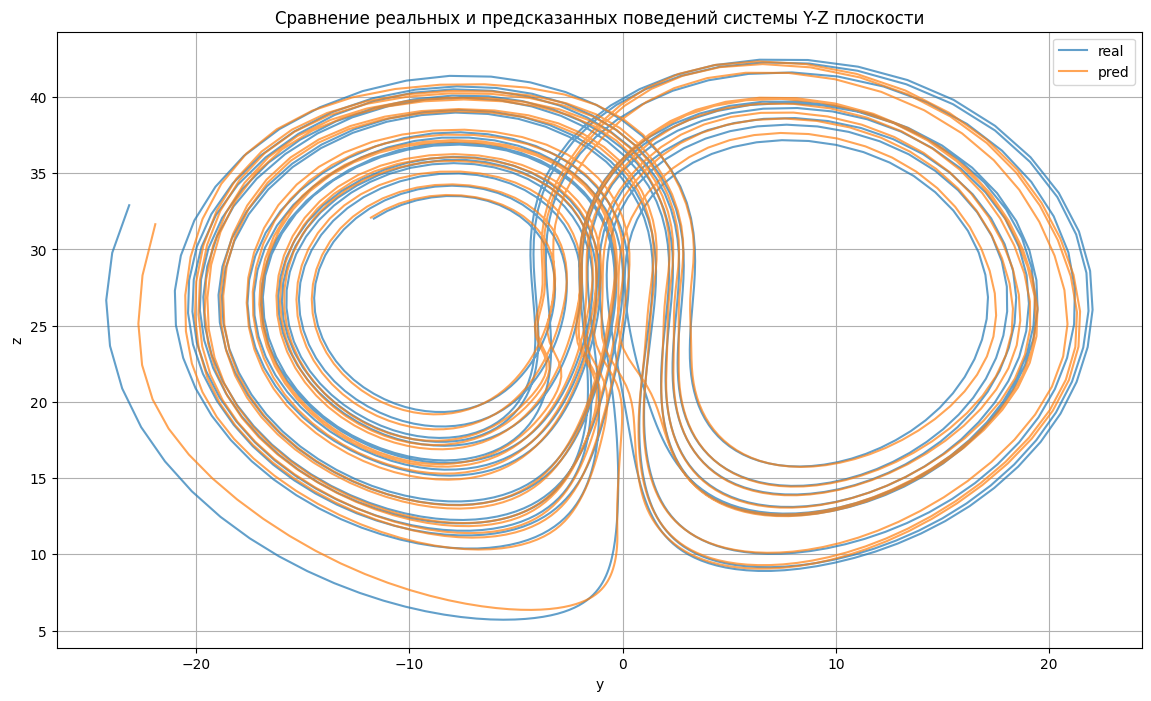

In [60]:
def plot_2d_comparison_yz(real, predicted, title):
    plt.figure(figsize=(14, 8))
    plt.plot(real[:, 1], real[:, 2],
             label='real', alpha=0.7)
    plt.plot(predicted[:, 1], predicted[:, 2],
             label='pred', alpha=0.7)

    plt.title(title)
    plt.xlabel('y')
    plt.ylabel('z')

    plt.legend()
    plt.grid(True)
    plt.show()


plot_2d_comparison_yz(
    y_test_actual,
    test_predict,
    title="Сравнение реальных и предсказанных поведений системы Y-Z плоскости"
    )